In [2]:
import pandas as pd
import numpy as np
from scipy.integrate import quad
import itertools

# Constant market (CRRA and Habit)

In [39]:
# Fixed parameters
t = 0
W = 1000
delta = 0.02

_lambda = 0.3
sigma = 0.2
r = 0.02

# Functions
def F(t, T, r, alpha, beta): # Needed for habit utility
    return (1 - np.exp(-(r + beta - alpha)*(T - t))) / (r + beta - alpha) 

def compute_allocation(h, gamma, T, alpha, beta): # Computes optimal allocation in the risky assets - in general form works for habit. Choose alpha, beta and h = 0 for CRRA
    f_val = F(t, T, r, alpha, beta)
    aktieandel = (_lambda / (gamma * sigma)) * (W - h * f_val) / W
    return aktieandel

# Parameter ranges
hs = [50]
gammas = [0.1,1,5,10,20,30]
Ts = [10]
alphas = [0.1]
betas = [0.2]

# Simulation
results = []

for h, gamma, T, alpha, beta in itertools.product(hs, gammas, Ts, alphas, betas):
    aktieandel = compute_allocation(h, gamma, T, alpha, beta)
    cash_position = 1 - aktieandel
    results.append({
        'h': h,
        'gamma': gamma,
        'T': T,
        'alpha': alpha,
        'beta': beta,
        'stock_weight_%': round(aktieandel * 100, 2),
        'cash_weight_%': round(cash_position * 100, 2),
        'stock/cash ratio': aktieandel/cash_position
    })

# Output
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

 h  gamma  T  alpha  beta  stock_weight_%  cash_weight_%  stock/cash ratio
50    0.1 10    0.1   0.2         1063.25        -963.25         -1.103816
50    1.0 10    0.1   0.2          106.32          -6.32        -16.811181
50    5.0 10    0.1   0.2           21.26          78.74          0.270082
50   10.0 10    0.1   0.2           10.63          89.37          0.118975
50   20.0 10    0.1   0.2            5.32          94.68          0.056147
50   30.0 10    0.1   0.2            3.54          96.46          0.036744


# Stochastic market (CRRA and Habit)

In [ ]:
# Parameters
t = 0 
W = 1000
delta = 0.02 
kappa = 0.3

gamma = 30

T = 10
r = 0.02

Lambda = 0.3
Lambda_cap = 0.3

Sigma = 0.2 #sigma lambda
sigma = 0.2

h = 50
alpha = 0.1
beta = 0.2

# Auxiliary functions
b = kappa - (1 - 1/gamma) * Sigma
theta = np.sqrt(b**2 - (Sigma**2 * (1 - gamma)) / gamma**2)

def A0(t, T):
    term1 = -(delta / gamma) * (T - t)
    term2 = -r * (1 - 1/gamma) * (T - t)
    term3 = -0.5 * np.log((2 * theta - (theta - b) * (1 - np.exp(-2 * theta * (T - t)))) / (2 * theta))
    term4 = ((1 - gamma) / (2 * gamma**2)) * (
        ((kappa**2 * Lambda_cap**2) / theta**2 + Sigma**2 / (theta + b)) * (T - t) +
        ((kappa**2 * Lambda_cap**2) / theta**3) *
        ((theta - 2 * b) * np.exp(-2 * theta * (T - t)) + 4 * b * np.exp(-theta * (T - t)) - theta - 2 * b) /
        (2 * theta - (theta - b) * (1 - np.exp(-2 * theta * (T - t))))
    )
    return term1 + term2 + term3 + term4

def A1(t, T):
    return ((1 - gamma) / gamma**2) * (kappa * Lambda_cap / theta) * ((1 - np.exp(-theta * (T - t)))**2) / \
           (2 * theta - (theta - b) * (1 - np.exp(-2 * theta * (T - t))))

def A2(t, T):
    return ((1 - gamma) / gamma**2) * (1 - np.exp(-2 * theta * (T - t))) / \
           (2 * theta - (theta - b) * (1 - np.exp(-2 * theta * (T - t))))

def F(t, T):
    return (1 - np.exp(-(r + beta - alpha) * (T - t))) / (r + beta - alpha)

def numerator_D1(t, T):
    integrand = lambda s: (A1(t, s) + A2(t, s) * Lambda) * (1 + alpha * F(s, T))**(1 - 1/gamma) * \
               np.exp(A0(t, s) + A1(t, s) * Lambda + 0.5 * A2(t, s) * Lambda**2)
    result, _ = quad(integrand, t, T, limit=200)
    return result

def denominator_D1(t, T):
    integrand = lambda s: (1 + alpha * F(s, T))**(1 - 1/gamma) * \
               np.exp(A0(t, s) + A1(t, s) * Lambda + 0.5 * A2(t, s) * Lambda**2)
    result, _ = quad(integrand, t, T, limit=200)
    return result

def D1(t, T):
    return numerator_D1(t, T) / denominator_D1(t, T)

# Safe ratio calculation function
def safe_divide(numerator, denominator):
    if np.isclose(denominator, 0):
        return 0
    else:
        return numerator / denominator

# Portfolio weights
my = Lambda / (gamma * sigma) * (W - h * F(t, T)) / W
hed = -(Sigma / sigma) * D1(t, T) * (W - h * F(t, T)) / W

# Total stock weight
total_stock_weight = my + hed

# Cash weight
cash_weight = 1 - total_stock_weight

# Safe Ratios
myopic_hedging_ratio = safe_divide(hed, my)

# Print results
print(f"Myopic weight (%): {my*100:.1f}")
print(f"Hedging weight (%): {hed*100:.1f}")
print(f"Total stock weight (%): {total_stock_weight*100:.1f}")
print(f"Cash weight (%): {cash_weight*100:.1f}")
print(f"Hedging-to-myopic ratio: {myopic_hedging_ratio:.1f}")


Myopic weight (%): 3.5
Hedging weight (%): 3.1
Hedging-to-myopic ratio: 0.9


# Graph for constant market Habit

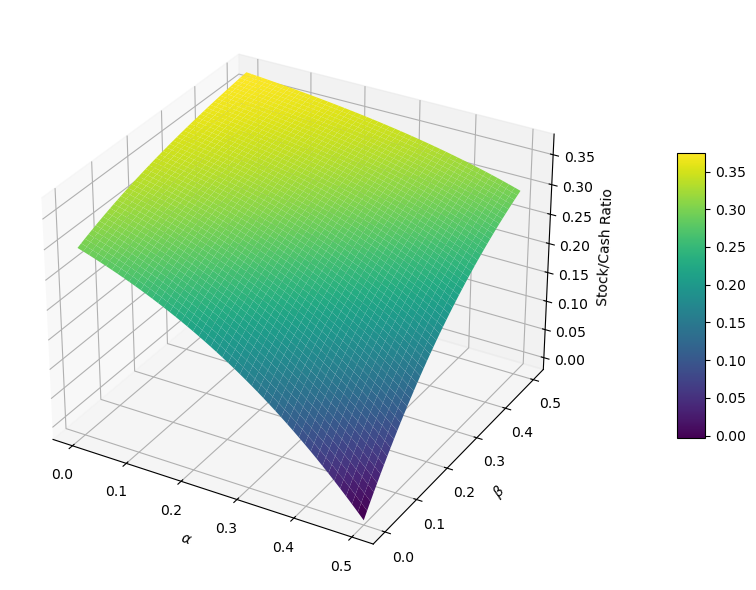

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Fixed parameters
t = 0
W = 1000
delta = 0.02
_lambda = 0.3
sigma = 0.2
r = 0.02
gamma = 5
T = 5
h = 50

# Functions
def F(t, T, r, alpha, beta):
    return (1 - np.exp(-(r + beta - alpha)*(T - t))) / (r + beta - alpha)

def compute_stock_cash_ratio(h, gamma, T, alpha, beta):
    f_val = F(t, T, r, alpha, beta)
    stock_weight = (_lambda / (gamma * sigma)) * (W - h * f_val) / W
    cash_position = 1 - stock_weight
    return stock_weight / cash_position if cash_position != 0 else np.nan

# Vectors
alphas = np.linspace(0, 0.5, 50)
betas = np.linspace(0, 0.5, 50)

# Stock/Cash ratios
ratios_1 = [compute_stock_cash_ratio(h, gamma, T, a, 0.1) for a in alphas]             # Increasing alpha
ratios_2 = [compute_stock_cash_ratio(h, gamma, T, 0.1, b) for b in betas]             # Increasing beta

# 3D surface: meshgrid and ratio computation
A, B = np.meshgrid(alphas, betas)
Z = np.array([[compute_stock_cash_ratio(h, gamma, T, a, b) for a, b in zip(row_a, row_b)]
              for row_a, row_b in zip(A, B)])

# Plot 3D surface
fig2 = plt.figure(figsize=(10, 6))
ax3d = fig2.add_subplot(111, projection='3d')
surf = ax3d.plot_surface(A, B, Z, cmap='viridis', edgecolor='none')

ax3d.set_xlabel("$\\alpha$")
ax3d.set_ylabel("$\\beta$")
ax3d.set_zlabel("Stock/Cash Ratio")

fig2.colorbar(surf, ax=ax3d, shrink=0.5, aspect=10, pad=0.1)
fig2.tight_layout()
plt.show()


# Graph for stochastic market Habit

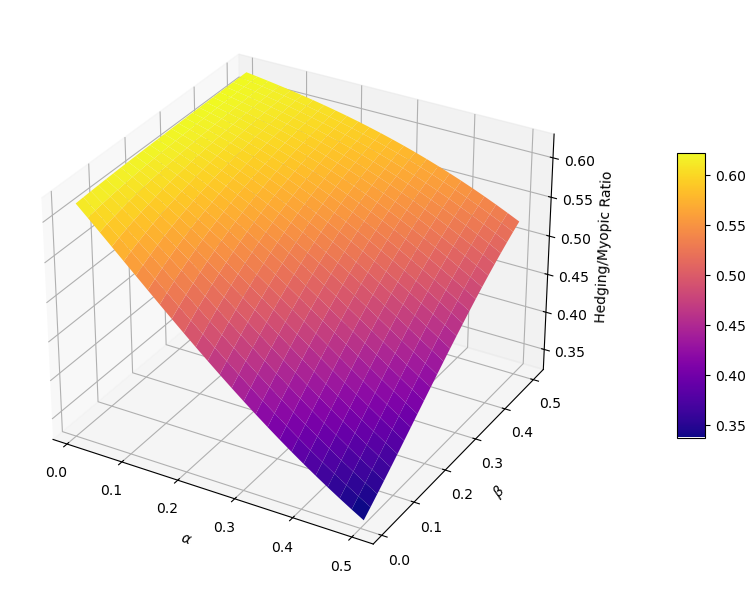

In [44]:
# Parameters
t = 0 
W = 1000
delta = 0.02 
kappa = 0.3
gamma = 5
T = 10 
r = 0.02
Lambda = 0.3
Lambda_cap = 0.3
Sigma = 0.2
sigma = 0.2
h = 0

# Grid of alpha and beta
alpha_vals = np.linspace(0.01, 0.5, 25)
beta_vals = np.linspace(0.01, 0.5, 25)
A, B = np.meshgrid(alpha_vals, beta_vals)

# Compute hedging/myopic ratio
Z = np.zeros_like(A)

for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        alpha = A[i, j]
        beta = B[i, j]
        f_val = F(t, T, r, alpha, beta)
        myopic = (Lambda / (gamma * sigma)) * (W - h * f_val) / W
        hedging = -(Sigma / sigma) * D1(t, T, alpha, beta) * (W - h * f_val) / W
        Z[i, j] = safe_divide(hedging, myopic)

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(A, B, Z, cmap='plasma', edgecolor='none')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.set_zlabel("Hedging/Myopic Ratio")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)
plt.tight_layout()
plt.show()
